<a href="https://colab.research.google.com/github/rahmatmamat1/Project_DataScience/blob/main/Stock_Analysis_and_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Analysis and Portfolio Optimization

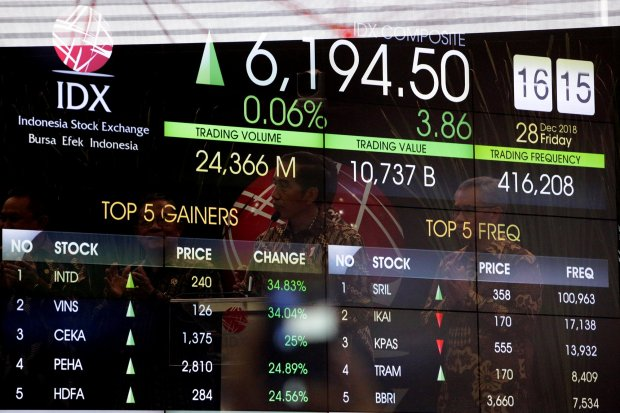

Investing in the **stock market** is risky as the value of stock prices can fluctuate heavily. Because of the inherent risk involved with investing in a single stock, **most professional portfolio managers diversify their investments to reduce** their risk from exposure to any one company. By investing in a **collection of stocks, also called a portfolio**, investors typically can get a better risk-reward trade-off.


So why then, do we need portfolio analysis? Well, when you invest in 1 stock, you easily can calculate the risk and possible pay-off. However, when you decide to create a portfolio of say 50 stocks, understanding even the possible pay-off, or return, becomes difficult. And how about comparing different portfolios of different size, and different lengths of history? How do you actually compare those and decide what the better investment is? That's where portfolio analysis comes in.


## Import libraries

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.2 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 3.0 MB/s 
     |████████████████████████████████| 2.8 MB 10.2 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yfinance as yf
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

## Data Preparation

### Stock Data

In [4]:
# Pick stocks
ticker = ['BBCA.JK', 'BBNI.JK', 'BBTN.JK', 'PTBA.JK', 'ASII.JK']

In [5]:
# Load stocks data
data = pd.DataFrame()
for i in ticker:
  obj = yf.Ticker(i)
  shm = obj.history(start='2020-06-01', end='2022-05-10')
  data = pd.concat([data,shm['Close']], axis=1)
  data.rename(columns = {'Close':i[:-3]}, inplace = True)

data.dropna(inplace=True)
data

,BBCA,BBNI,BBTN,PTBA,ASII
2020-06-02,5173.033691,3868.359619,912.932861,1748.097656,4333.369629
2020-06-03,5578.384277,4024.263428,996.823975,1773.310547,4479.952637
2020-06-04,5588.035156,4034.007324,962.280579,1832.140747,4360.854004
2020-06-05,5525.303223,4141.190918,1041.236938,1857.353760,4580.728516
2020-06-08,5694.198730,4706.341797,1159.671509,1932.992676,4603.632324
...,...,...,...,...,...
2022-04-25,8000.000000,9500.000000,1865.000000,3700.000000,6893.805176
2022-04-26,8125.000000,9600.000000,1835.000000,3640.000000,7015.604004
2022-04-27,8200.000000,9450.000000,1835.000000,3700.000000,6942.524902
2022-04-28,8125.000000,9225.000000,1845.000000,3820.000000,7381.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 470 entries, 2020-06-02 00:00:00 to 2022-05-09 00:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BBCA    470 non-null    float64
 1   BBNI    470 non-null    float64
 2   BBTN    470 non-null    float64
 3   PTBA    470 non-null    float64
 4   ASII    470 non-null    float64
dtypes: float64(5)
memory usage: 22.0+ KB


### Benchmark Data

Most actively managed portfolios are fixed to a **benchmark**. The benchmark serves as a reference of what the investor otherwise could earn, aka it serves as an indication of opportunity costs. An example of a benchmark is the **IHSG( Indeks Harga Saham Gabungan)**. The portfolio manager takes deliberate deviations from the benchmark, in order to beat it in terms of performance. In those cases, portfolio performance is always considered relative to its benchmark, and never as a total return.

In [7]:
ihsg = pd.DataFrame()
obj = yf.Ticker(i)
shm = obj.history(start='2020-06-01', end='2022-05-10').Close
ihsg = pd.concat([ihsg,shm], axis=1)
ihsg.rename(columns = {'Close':'IHSG'}, inplace = True)
ihsg

,IHSG
2020-06-02,4333.369629
2020-06-03,4479.953125
2020-06-04,4360.854004
2020-06-05,4580.728516
2020-06-08,4603.632324
...,...
2022-04-25,6893.805176
2022-04-26,7015.604004
2022-04-27,6942.524902
2022-04-28,7381.000000


In [8]:
ihsg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 470 entries, 2020-06-02 00:00:00 to 2022-05-09 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IHSG    470 non-null    float64
dtypes: float64(1)
memory usage: 7.3+ KB


## Stock Analysis

,BBCA,BBNI,BBTN,PTBA,ASII
count,470.000000,470.000000,470.000000,470.000000,470.000000
mean,6574.427207,5874.183341,1563.557755,2476.434443,5323.785863
std,740.310253,1184.268954,230.423058,452.815223,602.142560
min,5173.033691,3868.359619,912.932861,1748.097656,4218.469727
25%,6023.269287,4891.419312,1358.296082,2075.021973,4885.051514
50%,6411.600830,5694.919922,1618.605347,2412.197388,5268.498047
75%,7239.056641,6676.802734,1727.170288,2734.374756,5678.701538
max,8200.000000,9600.000000,2121.952148,3820.000000,7381.000000


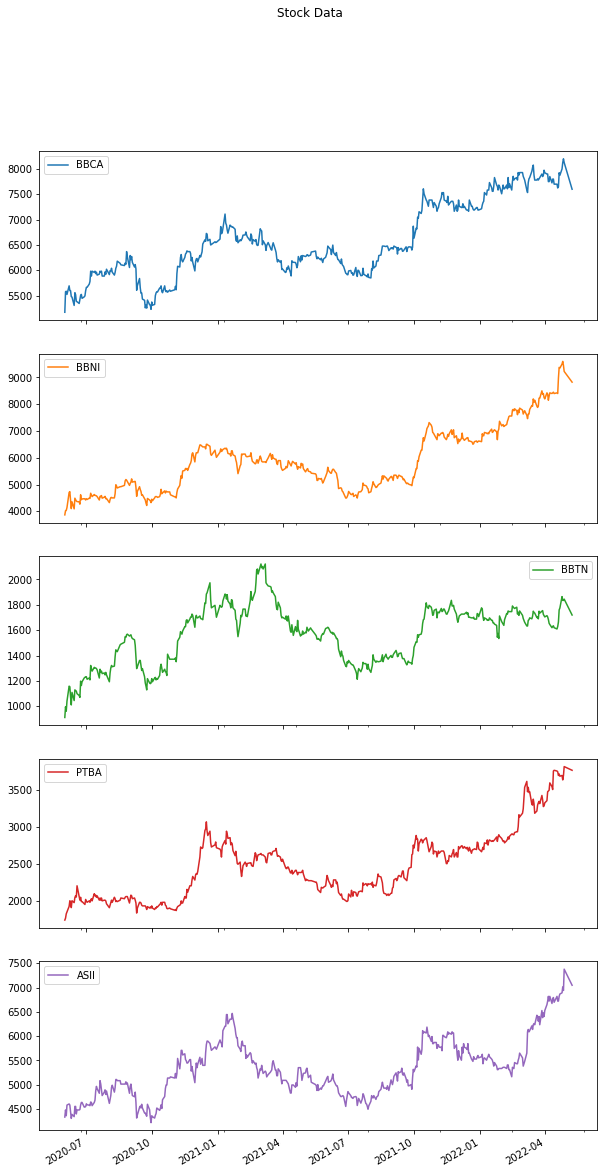

In [9]:
data.plot(subplots = True, title = 'Stock Data',figsize=(10,20))
data.describe()

,IHSG
count,470.000000
mean,5323.785844
std,602.142538
min,4218.470215
25%,4885.051514
50%,5268.498047
75%,5678.701660
max,7381.000000


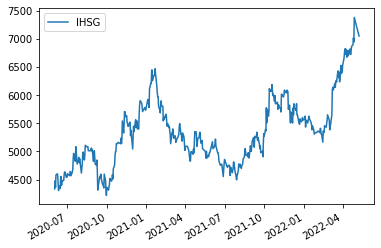

In [10]:
ihsg.plot()
ihsg.describe()

Calculate the percentage change in value from one day to the next

,BBCA,BBNI,BBTN,PTBA,ASII
count,469.000000,469.000000,469.000000,469.000000,469.000000
mean,0.000946,0.002032,0.001727,0.001895,0.001257
std,0.015870,0.023471,0.027683,0.022726,0.021022
min,-0.069656,-0.069959,-0.069767,-0.068627,-0.069388
25%,-0.008596,-0.012448,-0.013850,-0.010989,-0.012195
50%,0.000000,0.000000,-0.002532,0.000000,0.000000
75%,0.009360,0.014084,0.012780,0.013699,0.014218
max,0.078358,0.136471,0.134921,0.089231,0.077586


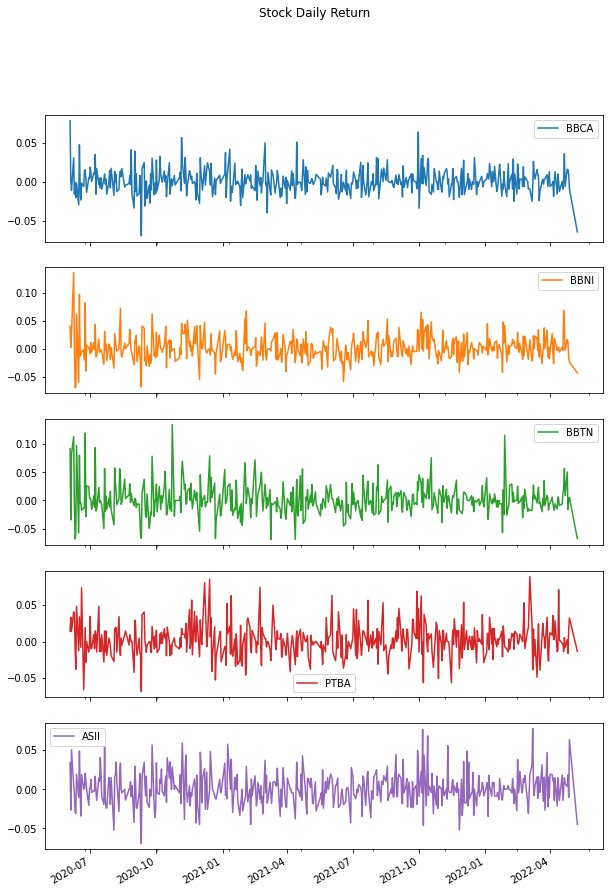

In [11]:
# Get percentage daily returns
stock_returns = data.pct_change()
stock_returns.plot(subplots = True, title = 'Stock Daily Return',figsize=(10,15))
stock_returns.describe()

,IHSG
count,469.000000
mean,0.001257
std,0.021022
min,-0.069388
25%,-0.012195
50%,0.000000
75%,0.014218
max,0.077586


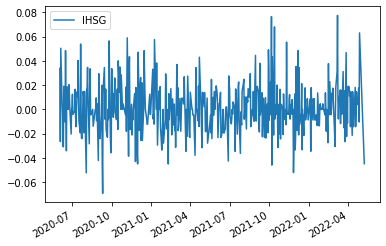

In [12]:
ihsg_day_returns = ihsg.pct_change()
ihsg_day_returns.plot()
ihsg_day_returns.describe()

### Cumulative Return

The cumulative return allows you to track total performance over time.


In [13]:
# Assign portfolio weights, assume weights are equal
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Create portfolio returns column
stock_returns['Portfolio']= stock_returns.dot(weights)
 
# Calculate cumulative returns
daily_cum_ret=(1+stock_returns).cumprod()

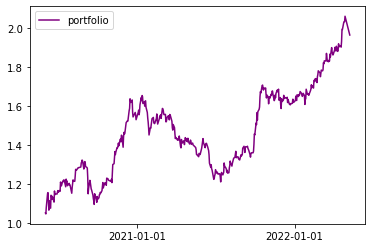

In [14]:
# Plot the portfolio cumulative returns only
fig, ax = plt.subplots()
ax.plot(daily_cum_ret.index, daily_cum_ret.Portfolio, color='purple', label="portfolio")
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
plt.legend()
plt.show()

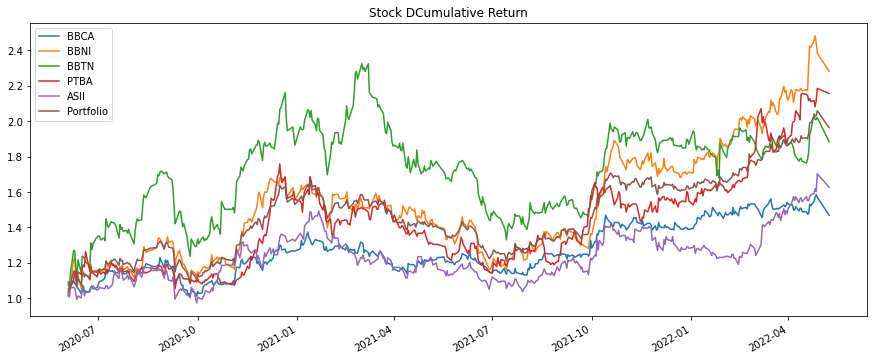

In [15]:
daily_cum_ret.plot(title = 'Stock DCumulative Return',figsize=(15,6))

## Measuring risk of portfolio

When you invest in stocks, you don't know beforehand what your return will be. Prices go up and down, so there is a degree of uncertainty, which implies that stock return is a random variable. The extend to which the actual returns are spread around their mean value is called variance.

$$\sigma^{2} = \frac{\sum \limits _{i=1} ^{N} (X-\mu)^{2}}{N}$$

Certain stock have a small variance, that means, their returns are always close the mean. Sometimes, stocks have a high variance and are widely spread around the mean.


In [16]:
# Calculate the covariance matrix 
cov_matrix = (stock_returns.iloc[:, 0:5].cov())*250
 
# Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
 
# Print the result
print(str(np.round(port_variance, 4) * 100) + '%')

6.67%


In [17]:
cov_matrix

,BBCA,BBNI,BBTN,PTBA,ASII
BBCA,0.062961,0.049857,0.046763,0.025598,0.038100
BBNI,0.049857,0.137726,0.109614,0.048144,0.058267
BBTN,0.046763,0.109614,0.191587,0.048409,0.062511
PTBA,0.025598,0.048144,0.048409,0.129122,0.031108
ASII,0.038100,0.058267,0.062511,0.031108,0.110486


BBTN is the riskiest, since it's variance is 19.1%, which is the highest of all the stocks in the portfolio. the variances of the stocks are in the diagonal of the covariance matrix. The variance tell us how much the returns of individual stocks deviate from their mean. BBTN seems to have relatively the highest variance of them all.


## Annualized Return

An annualized total return is the geometric average amount of money earned by an investment each year over a given time period. The annualized return formula is calculated as a geometric average to show what an investor would earn over a period of time if the annual return was compounded.

### IHSG

In [18]:
# number of period
months = 23

In [19]:
# Calculate the total return from the S&P500 value series
ihsg_total_return = (ihsg['IHSG'][-1] - ihsg['IHSG'][0]) / ihsg['IHSG'][0]
# Annualize the total return spanning 4 years
ihsg_annualized_return = ((1 + ihsg_total_return)**(12/months))-1
print('IHSG')
print('Total Return : {}'.format(round(ihsg_total_return,3)))
print('Annualized Return : {}'.format(round(ihsg_annualized_return,3)))

IHSG
Total Return : 0.627
Annualized Return : 0.289


### Bank BCA

In [20]:
# Calculate total rate of return from start to end
total_return = (data['BBCA'][-1] - data['BBCA'][0]) / data['BBCA'][0]
# Annualize return
bbca_annualized_return = ((1 + total_return)**(12/months))-1
print('BBCA')
print('Total Return : {}'.format(round(total_return,3)))
print('Annualized Return : {}'.format(round(bbca_annualized_return,3)))

BBCA
Total Return : 0.469
Annualized Return : 0.222


### Bank BNI

In [21]:
# Calculate total rate of return from start to end
total_return = (data['BBNI'][-1] - data['BBNI'][0]) / data['BBNI'][0]
# Annualize return
bbni_annualized_return = ((1 + total_return)**(12/months))-1
print('BBNI')
print('Total Return : {}'.format(round(total_return,3)))
print('Annualized Return : {}'.format(round(bbni_annualized_return,3)))

BBNI
Total Return : 1.281
Annualized Return : 0.538


### Bank BTN

In [22]:
# Calculate total rate of return from start to end
total_return = (data['BBTN'][-1] - data['BBTN'][0]) / data['BBTN'][0]
# Annualize return
bbtn_annualized_return = ((1 + total_return)**(12/months))-1
print('BBTN')
print('Total Return : {}'.format(round(total_return,3)))
print('Annualized Return : {}'.format(round(bbtn_annualized_return,3)))

BBTN
Total Return : 0.884
Annualized Return : 0.392


### PT. Bukit Asam

In [23]:
# Calculate total rate of return from start to end
total_return = (data['PTBA'][-1] - data['PTBA'][0]) / data['PTBA'][0]

# Annualize return
ptba_annualized_return = ((1 + total_return)**(12/months))-1

print('PTBA')
print('Total Return : {}'.format(round(total_return,3)))
print('Annualized Return : {}'.format(round(ptba_annualized_return,3)))

PTBA
Total Return : 1.157
Annualized Return : 0.493


### Astra International

In [24]:
# Calculate total rate of return from start to end
total_return = (data['ASII'][-1] - data['ASII'][0]) / data['ASII'][0]

# Annualize return
asii_annualized_return = ((1 + total_return)**(12/months))-1

print('ASII')
print('Total Return : {}'.format(round(total_return,3)))
print('Annualized Return : {}'.format(round(asii_annualized_return,3)))

ASII
Total Return : 0.627
Annualized Return : 0.289


### Comparing Stocks and Benchmark

In [25]:
total_return = (data.iloc[-1] - data.iloc[0]) / data.iloc[0]

# Annualize return
annualized_return = ((1 + total_return)**(12/months))-1

print('Stocks')
print('Total Return : \n{}'.format(round(total_return,3)))
print('Annualized Return : \n{}'.format(round(annualized_return,3)))
print()
print('IHSG')
print('Total Return : \n{}'.format(round(ihsg_total_return,3)))
print('Annualized Return : \n{}'.format(round(ihsg_annualized_return,3)))

Stocks
Total Return : 
BBCA    0.469
BBNI    1.281
BBTN    0.884
PTBA    1.157
ASII    0.627
dtype: float64
Annualized Return : 
BBCA    0.222
BBNI    0.538
BBTN    0.392
PTBA    0.493
ASII    0.289
dtype: float64

IHSG
Total Return : 
0.627
Annualized Return : 
0.289


## Sharpe Ratio


The Sharpe ratio was developed by Nobel laureate William F. Sharpe and is used to help investors understand the return of an investment compared to its risk. The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. Volatility is a measure of the price fluctuations of an asset or portfolio.

$Sharpe Ratio = \frac {R_{p}-R_{f}}{\sigma _{p}}$


Where:<br>
&emsp;&emsp;$R_{p} = $ Return of portfolio/stock<br>
&emsp;&emsp;$R_{f} = $ risk-Free rate<br>
&emsp;&emsp;$\sigma _{p} = $ Portfolio/stock standard deviation

### IHSG

In [26]:
# Risk free rate
rfr = 0.01

# Create the returns data 
returns_ihsg = ihsg['IHSG'].pct_change()
 
# Calculate annualized volatility from the standard deviation
vol_ihsg = returns_ihsg.std() * np.sqrt(250)
 
# Calculate the Sharpe ratio 
sharpe_ratio = ((ihsg_annualized_return - rfr) / vol_ihsg)
print(sharpe_ratio)

0.8395768944528295


In [27]:
# Calculate total return and annualized return from price data 
total_return = (data.iloc[-1,0:5] - data.iloc[0,0:5]) / data.iloc[0,0:5]
 
# Annualize the total return over 4 year 
annualized_return = ((1 + total_return)**(12/months))-1
 
# Create the returns data 
pf_returns = data.iloc[:, 0:5].pct_change()
 
# Calculate annualized volatility from the standard deviation
vol_pf = pf_returns.std()*np.sqrt(250)
 
# Calculate the Sharpe ratio 
sharpe_ratio = ((annualized_return - rfr) /vol_pf)
print(sharpe_ratio)

BBCA    0.845954
BBNI    1.422021
BBTN    0.871894
PTBA    1.344954
ASII    0.839577
dtype: float64


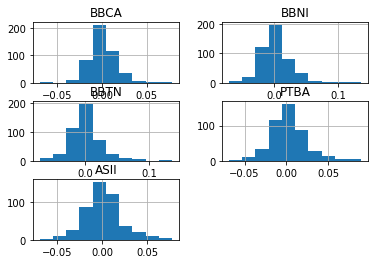

skew :  BBCA    0.425638
BBNI    0.758059
BBTN    1.044495
PTBA    0.561400
ASII    0.371614
dtype: float64
kurt :  BBCA    2.937329
BBNI    3.151255
BBTN    3.442585
PTBA    1.640346
ASII    0.949390
dtype: float64


In [28]:
# # Print skewness and kurtosis of the stocks
# print ("skew : ", stock_returns.skew())
# print ("kurt : ", stock_returns.kurtosis())
 
# Print the histogram of the portfolio
pf_returns.hist()
plt.show()
 
# Print skewness and kurtosis of the portfolio
print ("skew : ", pf_returns.skew())
print ("kurt : ", pf_returns.kurtosis())

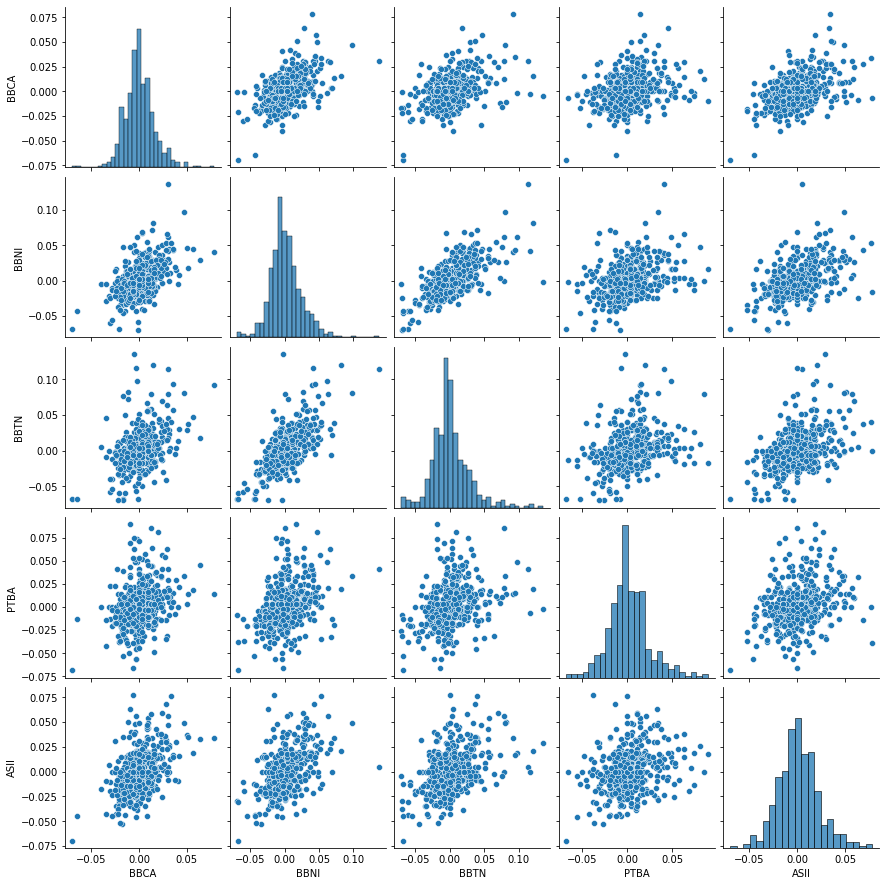

In [29]:
sns.pairplot(pf_returns)

## Portfolio Optimization

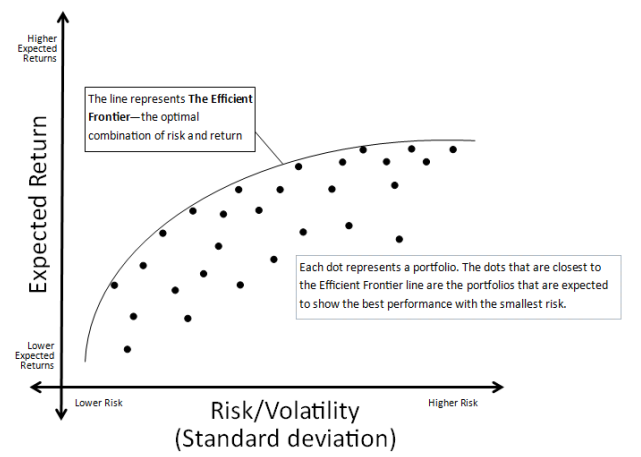

Harry Markowitz came up with Efficient Frontier Optimization in 1952, which provides a solid framework for combining stocks in a portfolio. The key insight is that by combining assets with different expected returns and volatilities, one can decide on a mathematically optimal allocation.The Efficient Frontier Optimization is a constrained optimization problem, in which you try to minimize portfolio variance by setting the weights.


In [30]:
# Calculate expected returns mu 
mu = expected_returns.mean_historical_return(data)
 
# Calculate the covariance matrix S
Sigma = risk_models.sample_cov(data)
print(mu, Sigma)

BBCA    0.229612
BBNI    0.557612
BBTN    0.405430
PTBA    0.511270
ASII    0.298878
dtype: float64           BBCA      BBNI      BBTN      PTBA      ASII
BBCA  0.063465  0.050256  0.047137  0.025803  0.038404
BBNI  0.050256  0.138827  0.110491  0.048529  0.058733
BBTN  0.047137  0.110491  0.193120  0.048796  0.063012
PTBA  0.025803  0.048529  0.048796  0.130155  0.031357
ASII  0.038404  0.058733  0.063012  0.031357  0.111369


In [31]:
ef = EfficientFrontier(mu, Sigma)
ef.efficient_return(0.4)
weights = ef.clean_weights()
print(weights)
 
# Show portfolio performance 
ef.portfolio_performance(verbose=True)

OrderedDict([('BBCA', 0.32833), ('BBNI', 0.20735), ('BBTN', 0.0), ('PTBA', 0.3306), ('ASII', 0.13372)])
Expected annual return: 40.0%
Annual volatility: 24.0%
Sharpe Ratio: 1.58


(0.4000000000000001, 0.23984611496204758, 1.5843491984855786)

efficient_return() you get the maximum return portfolio for a given target risk


In [32]:
ef = EfficientFrontier(mu, Sigma)
ef.efficient_risk(0.23)
weights = ef.clean_weights()
print(weights)
 
# Show portfolio performance 
ef.portfolio_performance(verbose=True)

OrderedDict([('BBCA', 0.43599), ('BBNI', 0.11884), ('BBTN', 0.0), ('PTBA', 0.28926), ('ASII', 0.15591)])
Expected annual return: 36.1%
Annual volatility: 23.0%
Sharpe Ratio: 1.48


(0.3608623759460341, 0.23000000132396986, 1.4820103216691178)

efficient_risk() you get the maximum return portfolio for a given target risk

### Maximum Sharpe Ratio

max_sharpe() provides the highest possible return to risk ratio



In [33]:
# Calculate weights for the maximum Sharpe ratio portfolio
ef1 = EfficientFrontier(mu, Sigma)
raw_weights_maxsharpe = ef1.max_sharpe()
cleaned_weights_maxsharpe = ef1.clean_weights()
 
# Show portfolio performance 
print(cleaned_weights_maxsharpe)
perf_max_sharpe = ef1.portfolio_performance(verbose=True)

OrderedDict([('BBCA', 0.0), ('BBNI', 0.49273), ('BBTN', 0.0), ('PTBA', 0.46166), ('ASII', 0.04561)])
Expected annual return: 52.4%
Annual volatility: 29.6%
Sharpe Ratio: 1.70


min_volatility() gives minimum volatility portfolio

In [34]:
# Calculate weights for the minimum volatility portfolio
ef2 = EfficientFrontier(mu, Sigma)
raw_weights_minvol = ef2.min_volatility()
cleaned_weights_minvol = ef2.clean_weights()
 
# Show portfolio performance
print(cleaned_weights_minvol)
perf_min_volatility = ef2.portfolio_performance(verbose=True)

OrderedDict([('BBCA', 0.58945), ('BBNI', 0.0), ('BBTN', 0.0), ('PTBA', 0.22525), ('ASII', 0.1853)])
Expected annual return: 30.6%
Annual volatility: 22.4%
Sharpe Ratio: 1.27


In [35]:
print('Weigths of portfolio with max sharpe ratio: {}'.format(cleaned_weights_maxsharpe))
print('Weigths of portfolio with min volatility: {}'.format(cleaned_weights_minvol))
print('\nPerformance of portfolio with max sharpe ratio:')
_ = ef1.portfolio_performance(verbose=True)
print('\nPerformance of portfolio with min volatility:')
_ = ef2.portfolio_performance(verbose=True)

Weigths of portfolio with max sharpe ratio: OrderedDict([('BBCA', 0.0), ('BBNI', 0.49273), ('BBTN', 0.0), ('PTBA', 0.46166), ('ASII', 0.04561)])
Weigths of portfolio with min volatility: OrderedDict([('BBCA', 0.58945), ('BBNI', 0.0), ('BBTN', 0.0), ('PTBA', 0.22525), ('ASII', 0.1853)])

Performance of portfolio with max sharpe ratio:
Expected annual return: 52.4%
Annual volatility: 29.6%
Sharpe Ratio: 1.70

Performance of portfolio with min volatility:
Expected annual return: 30.6%
Annual volatility: 22.4%
Sharpe Ratio: 1.27


In [37]:
# # Define exponentially weightedSigma and mu using stock_prices
# Sigma = risk_models.exp_cov(data_stocks, span=180, frequency=252)
# mu = expected_returns.ema_historical_return(data_stocks, frequency=252, span=180)
 
# # Calculate the efficient frontier
# ef3 = EfficientFrontier(mu, Sigma)
 
# # Calculate weights for the maximum sharpe ratio optimization
# raw_weights_maxsharpe = ef3.max_sharpe()
# cleaned_weights_maxsharpe_EW = ef3.clean_weights()
 
# # Show portfolio performance 
# ef3.portfolio_performance(verbose=True)

In [ ]:
# # Print the weights of both portfolios types
# print(cleaned_weights_maxsharpe, cleaned_weights_maxsharpe_EW, sep="\n")
 
# # Print the performance of both portfolios types
# perf_max_sharpe = ef1.portfolio_performance(verbose=True)
# perf_max_sharpe_EW = ef3.portfolio_performance(verbose=True)